# Projet : Segmenter des clients d'un site de e-commerce : Notebook de simulations et analyse de la stabilité temporelle

L'expérience d'achat d'un client peut évoluer dans le temps et influencer de façon considérable la segmentation initialement définie.
La question centrale est celle de savoir quand faut-il réentraîner le modèle afin que la segmentation reste pertinence et continuer à fournir aux équipes de gestion des clients les informations adéquates pour une amélioration continue des services?

### Approche mise en place

- L’ensemble des données couvrent environ 24 mois,
- Initialisation d’une période de référence T0 correspondant à (12 mois d’achats) et entraînement d’une modèle KMeans à 5 clusters,
- Définition d’une variable d’incrémentation pour chaque période supplémentaire (un mois supplémentaire d’achats)
- Tn = T0 + n mois
- Prédictions pour chaque période supplémentaire sur la base du modèle entraîné à T0.
- Entraînement du modèle à Tn et comparaison via le score ARI entre T0 et Tn avec un seuil minimum fixé à 0,8.

In [1]:
# Importation des librairies nécessaires

%matplotlib inline
from time import time
from datetime import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

mpl.rcParams["figure.figsize"] = (12, 8)
warnings.filterwarnings('ignore')

In [2]:
# Chargement des différentes données utiles
orders = pd.read_csv("olist_orders_dataset.csv",sep=",",low_memory=False)
customers = pd.read_csv("olist_customers_dataset.csv",sep=",",low_memory=False)
items = pd.read_csv("olist_order_items_dataset.csv",sep=",",low_memory=False)
sellers = pd.read_csv("olist_sellers_dataset.csv",sep=",",low_memory=False)
products = pd.read_csv("olist_products_dataset.csv",sep=",",low_memory=False)
category = pd.read_csv("product_category_name_translation.csv",sep=",",low_memory=False)
payments = pd.read_csv("olist_order_payments_dataset.csv",sep=",",low_memory=False)
reviews = pd.read_csv("olist_order_reviews_dataset.csv",sep=",",low_memory=False)

In [3]:
payment = payments.groupby("order_id").agg({"payment_value" : "sum", 
                                            "payment_sequential" : "max"}).reset_index()

In [4]:
review = reviews.groupby("order_id")["review_score"].min()

In [5]:
item = items.groupby("order_id").agg({"order_item_id" : "max",
                                          "seller_id" : "count", 
                                          "price" : "mean",
                                          "freight_value" : "mean"}).reset_index()

In [6]:
order = orders.loc[~((orders["order_status"] == "canceled") 
                     | (orders["order_status"] == "unavailable")), :]
order = pd.merge(order, payment, on="order_id", how="left")
order = pd.merge(order, item, on="order_id", how="left")
order = pd.merge(order, review, on="order_id", how="left")
print(order.shape)

(98207, 15)


In [7]:
custom_order = pd.merge(customers, order, on="customer_id", how="right")
print(custom_order.shape)
print(custom_order.columns)

(98207, 19)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_value', 'payment_sequential',
       'order_item_id', 'seller_id', 'price', 'freight_value', 'review_score'],
      dtype='object')


In [8]:
data_raw = custom_order[['customer_unique_id', 'order_id', 'order_purchase_timestamp',
                                      'payment_value', 'price', 'review_score']]

In [9]:
def prep_data (data) :
    '''Fonction de préparation des des diffrentes variables'''
   
    data["recence"] = (data["order_purchase_timestamp"].max()
                       -data["order_purchase_timestamp"]) / np.timedelta64(1, "D")
    data = data.groupby("customer_unique_id").agg({"recence" : "min", 
                                                   "order_id" : "count",
                                                   "payment_value" : "sum", 
                                                   "price" : "mean", 
                                                   "review_score" : "min"}).reset_index()
    data.rename(columns={"order_id" : "frequence", 
                         "payment_value" : "montant", 
                         "price" : "prix_moy", 
                         "review_score" : "note_min"}, inplace=True)
    data.drop("customer_unique_id", axis=1, inplace=True)
    data = data.dropna(axis=0)
    
    return data

In [10]:
def draw_silhouette (data) :
    '''Affiche un graphe avec le coeeficient de silhouette en fonction du nombre de clusters.'''
    
    silhouettes = []
    for n in range(2,8) : 
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data)
        silh = metrics.silhouette_score(data, kmeans.labels_)
        silhouettes.append(silh)

    plt.plot(range(2,8), silhouettes)
    plt.show()

In [11]:
def segmentation (data, kmeans_T0):
    '''Fonction effectuant une mise à l'échelle et un regroupement KMeans.
    
    Paramètres : 
    - data : DataFrame : données sur lesquelles le regroupement doit être effectué
    - kmeans_T0 : modèle KMeans ajusté sur les données au temps T0
    
    Résultats : 
    - labels : prédiction du modèle de clustering au nouveau moment
        - ari : Indice de Rand ajusté entre les deux segmentations à T0 et au nouveau moment
    '''
    scale = MinMaxScaler()
    data_norm = scale.fit_transform(data)
    labels_ref = kmeans_T0.predict(data_norm)
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(data_norm)
    centroids_norm = kmeans.cluster_centers_
    centroids = scale.inverse_transform(centroids_norm)
    labels = kmeans.labels_
    ari = metrics.adjusted_rand_score(labels_ref, labels)
        
    return labels, centroids, ari

In [12]:
def maintenance (data):
    '''Fonction affichant l'indice de Rand ajusté (ARI) entre les clusters
    en fonction du temps écoulé et des données ajoutées ou modifiées.'''
    
    # Préparation des données de référence pour une année de commandes : 
    data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
    start_T0 = data["order_purchase_timestamp"].min()
    end_T0 = start_T0 + relativedelta(years=1)
    
    mask_T0 = ((data["order_purchase_timestamp"] >= start_T0) & (data["order_purchase_timestamp"] < end_T0))
    data_T0 = data.loc[mask_T0]
    data_T0 = prep_data(data_T0) # DataFrame avec les 5 variables, recence, frequence, montant, prix_moy et note_min
    
    # Entrainement d'un KMeans (5 clusters) sur le DataFrame de référence : 
    scale_T0 = MinMaxScaler()
    data_T0_norm = scale_T0.fit_transform(data_T0)
    kmeans_T0 = KMeans(n_clusters = 5)
    kmeans_T0.fit(data_T0_norm)
    
    monthN = relativedelta(months=1)
    ari_Tn = []
    end_Tn = end_T0 + monthN # initiation à T0 + 1 mois
  
    while end_Tn < data["order_purchase_timestamp"].max() : 
        mask_Tn = ((data["order_purchase_timestamp"] >= start_T0) & (data["order_purchase_timestamp"] < end_Tn))
        data_Tn = data.loc[mask_Tn]
        data_Tn = prep_data(data_Tn)
        
        # Récupération de l'ARI entre les clusters avec ou sans entrainement au temps n: 
        l, c, ari = segmentation (data_Tn, kmeans_T0)
        ari_Tn.append(ari)
        
        end_Tn += monthN # incrementation d'un mois
    
    # Affichage de l'évolution des ARI dans le temps :
    x = range(2, len(ari_Tn)+2, 1) # absisse en nombre de mois
    plt.plot(x, ari_Tn)
    plt.axhline(y=0.8, linestyle="--", 
            color="red",
            linewidth=1)
    plt.title("Évolution de l'indice Rand ajusté (ARI) entre les clusters en fonction du nombre de mois.")
    plt.ylabel("Score ARI entre les clusters")
    plt.xlabel("Temps en nombre de mois")
    
    return ari_Tn

In [13]:
data_raw["order_purchase_timestamp"] = pd.to_datetime(data_raw["order_purchase_timestamp"])
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98207 entries, 0 to 98206
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        98207 non-null  object        
 1   order_id                  98207 non-null  object        
 2   order_purchase_timestamp  98207 non-null  datetime64[ns]
 3   payment_value             98206 non-null  float64       
 4   price                     98199 non-null  float64       
 5   review_score              97473 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 4.5+ MB


In [14]:
start_T0 = pd.Timestamp('2016-09-05')
end_T0 = pd.Timestamp('2017-09-30')
mask = ((data_raw["order_purchase_timestamp"] >= start_T0) 
        & (data_raw["order_purchase_timestamp"] < end_T0))
display(data_raw.loc[mask].shape)

(26975, 6)

In [15]:
dataset = data_raw.copy()
dataset["recence"] = (dataset["order_purchase_timestamp"].max()
                       -dataset["order_purchase_timestamp"]) / np.timedelta64(1, "D")
dataset = dataset.groupby("customer_unique_id").agg({"recence" : "min", 
                                                      "order_id" : "count",
                                                      "payment_value" : "sum", 
                                                      "price" : "mean", 
                                                      "review_score" : "min"}).reset_index()
dataset.rename(columns={"order_id" : "frequence", 
                        "payment_value" : "montant", 
                        "price" : "prix_moy", 
                        "review_score" : "note_min"}, inplace=True)
dataset.drop("customer_unique_id", axis=1, inplace=True)


In [16]:
dataset_T0 = data_raw.loc[mask]

In [17]:
dataset_T0 = prep_data(dataset_T0)
display(dataset_T0.head())
print(dataset_T0.shape)

,recence,frequence,montant,prix_moy,note_min
0,203.118947,1,86.22,69.00,3.0
1,209.016759,1,150.12,135.00,4.0
2,73.606366,1,29.00,13.90,3.0
3,49.424363,1,91.28,76.99,4.0
4,0.381505,1,46.85,35.00,4.0


(25980, 5)


In [18]:
scale_T0 = MinMaxScaler()
dataset_T0_norm = scale_T0.fit_transform(dataset_T0)

  File "C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


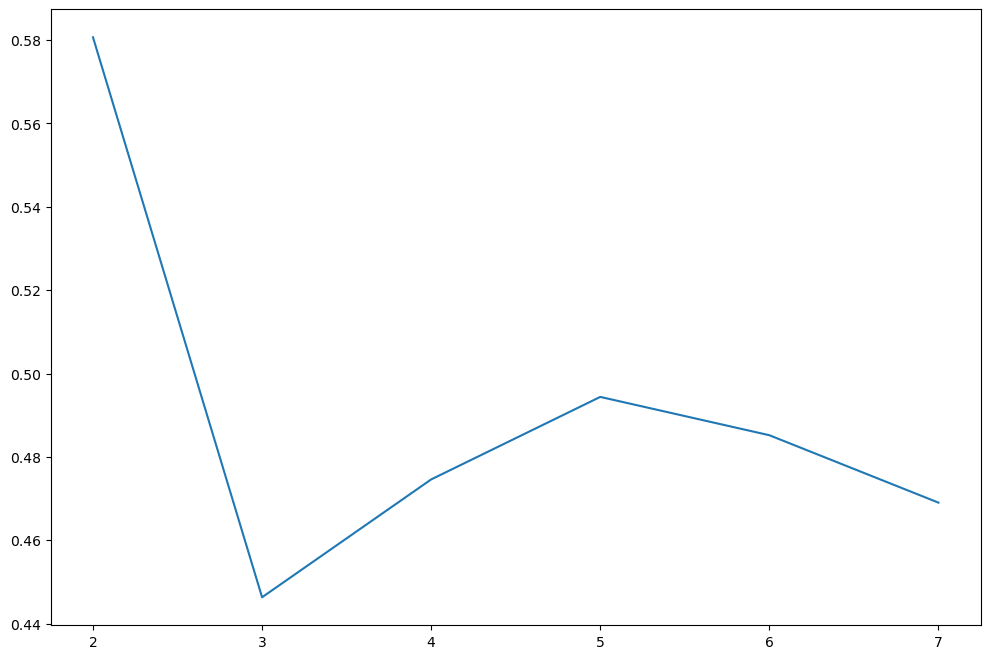

In [19]:
draw_silhouette(dataset_T0_norm)

In [20]:
kmeans_T0 = KMeans(n_clusters = 5)
kmeans_T0.fit(dataset_T0_norm)
dataset_T0["clusters"] = kmeans_T0.labels_
centroids_T0_norm = kmeans_T0.cluster_centers_

In [21]:
start_T1 = pd.Timestamp('2016-09-05')
end_T1 = pd.Timestamp('2017-10-30')
mask = ((data_raw["order_purchase_timestamp"] >= start_T1) 
        & (data_raw["order_purchase_timestamp"] < end_T1))
dataset_T1 = data_raw.loc[mask]


In [22]:
dataset_T1 = prep_data(dataset_T1)

In [23]:
labels_T1, centroids_T1, ari_T1 = segmentation(dataset_T1, kmeans_T0)

In [24]:
dataset_T1["clusters"] = labels_T1


In [25]:
print("Score ARI entre clusters à T0 et à T1 :", ari_T1)

Score ARI entre clusters à T0 et à T1 : 0.9672421089034389


In [26]:
# Définition de la période T0 d'un an : 
print(data_raw["order_purchase_timestamp"].min())
print(data_raw["order_purchase_timestamp"].min() + relativedelta(years=1))

2016-09-04 21:15:19
2017-09-04 21:15:19


In [27]:
end_Tn = end_T0
while end_Tn < data_raw["order_purchase_timestamp"].max() :
    print(end_Tn)
    end_Tn += relativedelta(months=1)

2017-09-30 00:00:00
2017-10-30 00:00:00
2017-11-30 00:00:00
2017-12-30 00:00:00
2018-01-30 00:00:00
2018-02-28 00:00:00
2018-03-28 00:00:00
2018-04-28 00:00:00
2018-05-28 00:00:00
2018-06-28 00:00:00
2018-07-28 00:00:00
2018-08-28 00:00:00


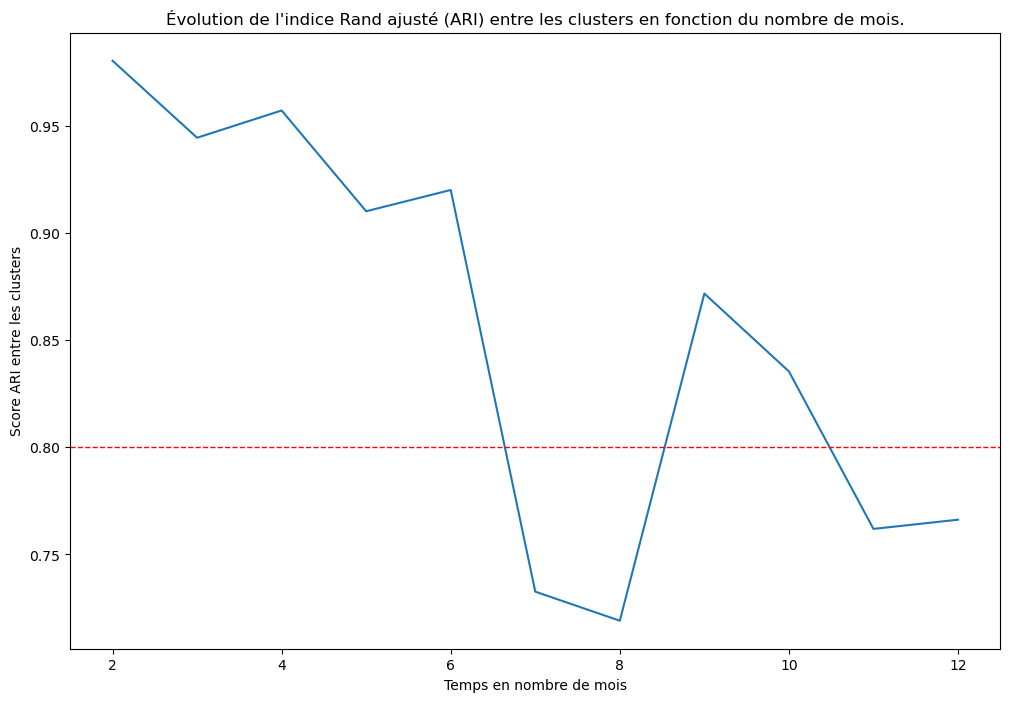

In [28]:
data_test = data_raw.copy()
liste_ari = maintenance(data_test)

### Conclusion

IL est nécessaire d’effectuer une maintenance du modèle initial après environ 6,5 mois.